In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from sklearn.linear_model import LogisticRegression

## Basic Overview
This database is a collection of labeled tweets. For some reason at first it didn't have any column names assinged so I had to do it myself. It contains:
- **id**: A unique identifier for a tweet.
- **category**: From my understanding it's a subject that a particular tweet reffers to.
- **type**: There are four types of messages: Positive, Negative, Irrelevant and Neutral. Author mentioned that messages that are not relevant to the category are regarded as Neutral (I decided that I won't make that distinction and I'll try to predict Irrelevant messages also).
- **text**: A content of a tweet.

Author gives this data in two files. The first is for training a model (74682 entries) and the second one is for testing (1000 entries). Unfortunately there isn't any information about how this data was labeled and upon further inspection I started to have doubts if labeling was executed right.

In [252]:
test_df = pd.read_csv('twitter_validation.csv', header=None)
train_df = pd.read_csv('twitter_training.csv', header=None)

In [253]:
test_df.columns = ['id', 'category', 'type', 'text']

In [254]:
test_df.head()

,id,category,type,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [255]:
train_df.columns = ['id', 'category', 'type', 'text']

In [256]:
train_df.head()

,id,category,type,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


### Missing Data
It turns out that train dataset contains missing values in text column. I deleted those entries. The test dataset seems to be okey.

In [257]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        74682 non-null  int64 
 1   category  74682 non-null  object
 2   type      74682 non-null  object
 3   text      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [258]:
train_df.isnull().sum()

id            0
category      0
type          0
text        686
dtype: int64

In [259]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1000 non-null   int64 
 1   category  1000 non-null   object
 2   type      1000 non-null   object
 3   text      1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [260]:
train_df.dropna(inplace=True, axis=0)

In [261]:
train_df.isnull().sum()

id          0
category    0
type        0
text        0
dtype: int64

### Categories
Both sets contain the same categories which are listed below.

In [262]:
distinct_categories_train = train_df['category'].unique()
distinct_categories_val = test_df['category'].unique()

categories_train_set = set(distinct_categories_train)
categories_val_set = set(distinct_categories_val)

print(categories_train_set == categories_val_set)

True


In [263]:
categories_train_set

{'Amazon',
 'ApexLegends',
 'AssassinsCreed',
 'Battlefield',
 'Borderlands',
 'CS-GO',
 'CallOfDuty',
 'CallOfDutyBlackopsColdWar',
 'Cyberpunk2077',
 'Dota2',
 'FIFA',
 'Facebook',
 'Fortnite',
 'Google',
 'GrandTheftAuto(GTA)',
 'Hearthstone',
 'HomeDepot',
 'LeagueOfLegends',
 'MaddenNFL',
 'Microsoft',
 'NBA2K',
 'Nvidia',
 'Overwatch',
 'PlayStation5(PS5)',
 'PlayerUnknownsBattlegrounds(PUBG)',
 'RedDeadRedemption(RDR)',
 'TomClancysGhostRecon',
 'TomClancysRainbowSix',
 'Verizon',
 'WorldOfCraft',
 'Xbox(Xseries)',
 'johnson&johnson'}

### Distribution of Emotion
Distribution of emotion (type column) in both sets seem to be similiar.

In [264]:
train_df['type'].value_counts()

type
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

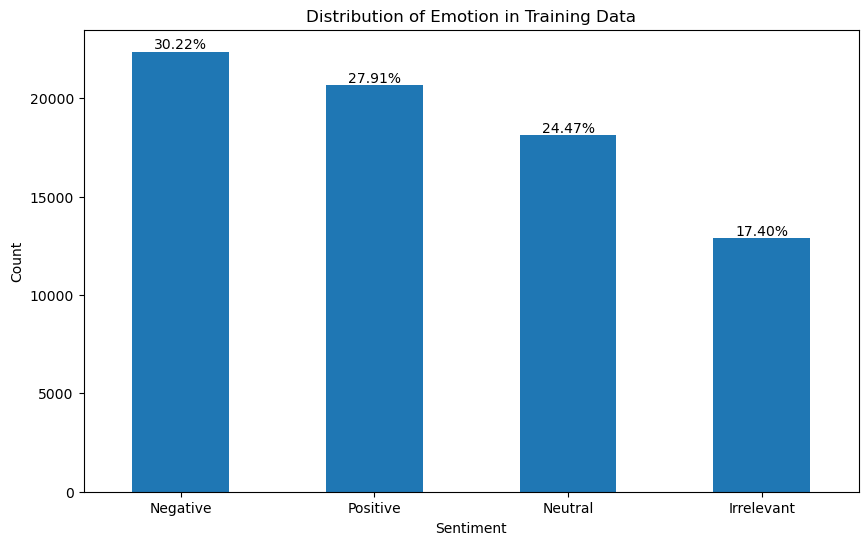

In [265]:
plt.figure(figsize=(10, 6))
train_df['type'].value_counts().plot(kind='bar')

total_samples_train = len(train_df)
for i, count in enumerate(train_df['type'].value_counts()):
    percentage = (count / total_samples_train) * 100
    plt.text(i, count, f'{percentage:.2f}%', ha='center', va='bottom')
    
plt.title('Distribution of Emotion in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [266]:
test_df['type'].value_counts()

type
Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: count, dtype: int64

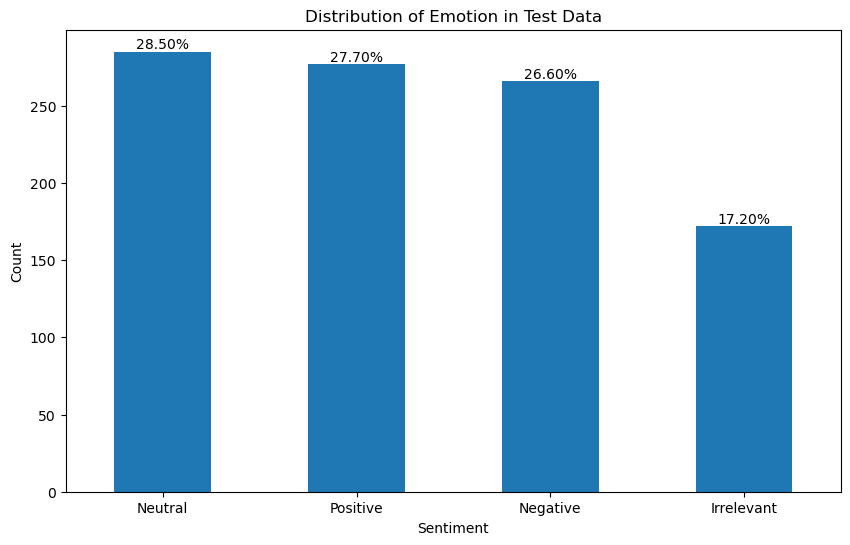

In [267]:
plt.figure(figsize=(10, 6))
test_df['type'].value_counts().plot(kind='bar')

total_samples_test = len(test_df)
for i, count in enumerate(test_df['type'].value_counts()):
    percentage = (count / total_samples_test) * 100
    plt.text(i, count, f'{percentage:.2f}%', ha='center', va='bottom')

plt.title('Distribution of Emotion in Test Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Text Length
Tweet lengths in both data set are about right. Whats worth noting is that the text isn't perfect - there are sometimes weird (they seem to appear without context), not alphanumeric characters. Additionally there are a few outliers in the training set.

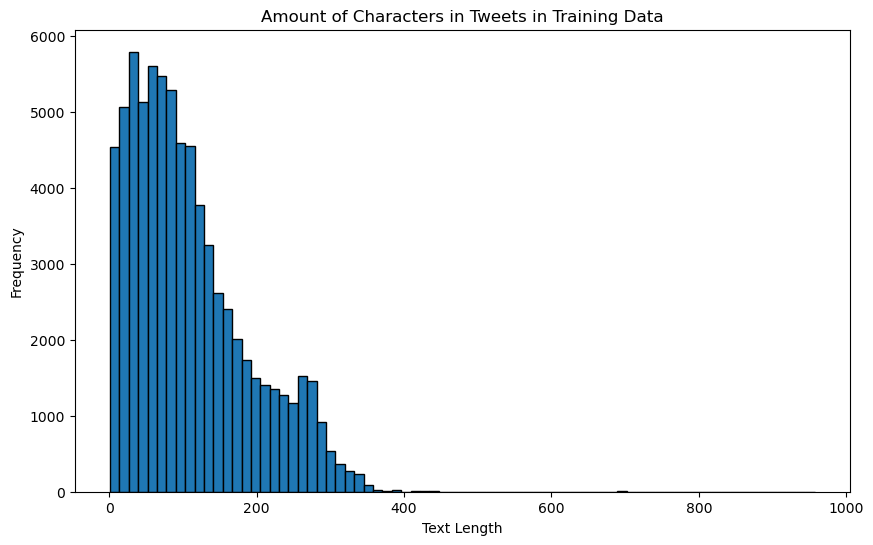

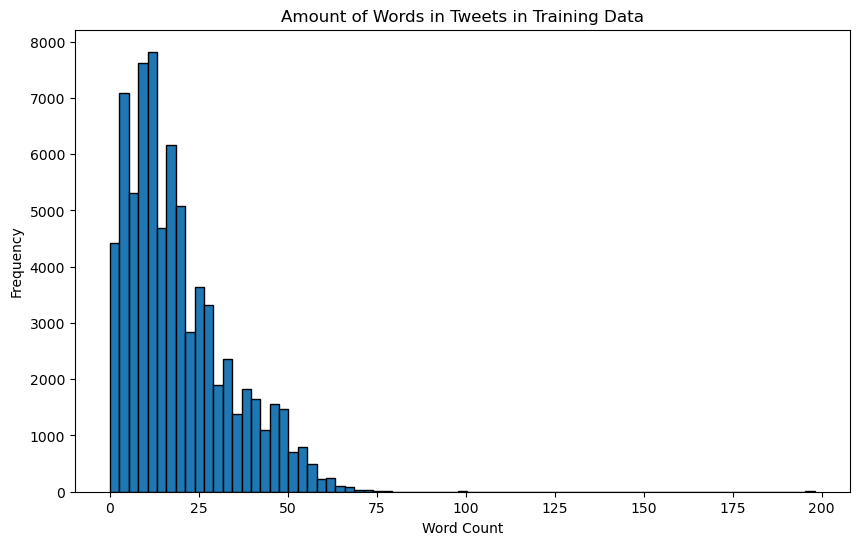

In [268]:
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
plt.hist(train_df['text_length'], bins=75, edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Amount of Characters in Tweets in Training Data')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(train_df['word_count'], bins=75, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Amount of Words in Tweets in Training Data')
plt.show()

In [269]:
print("Mean word count:", train_df['word_count'].mean())
print("Mean text length:", train_df['text_length'].mean())

Mean word count: 19.226620357857183
Mean text length: 108.78365046759285


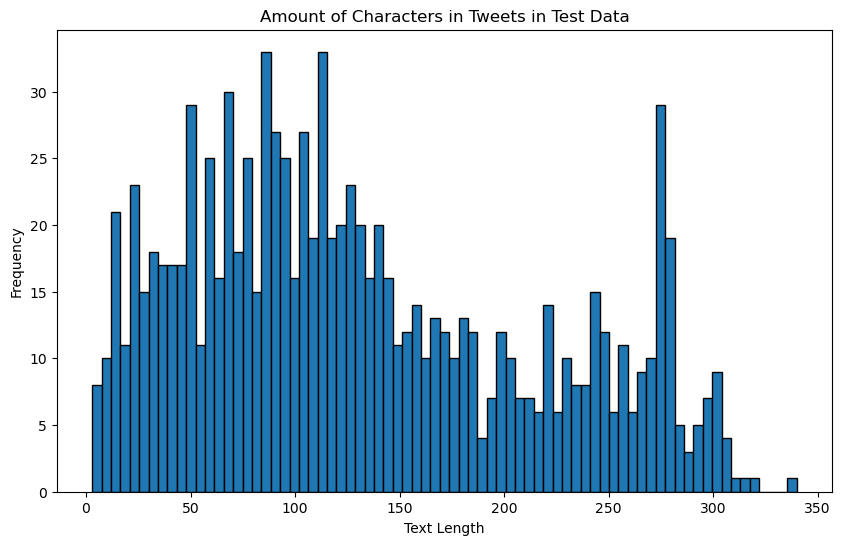

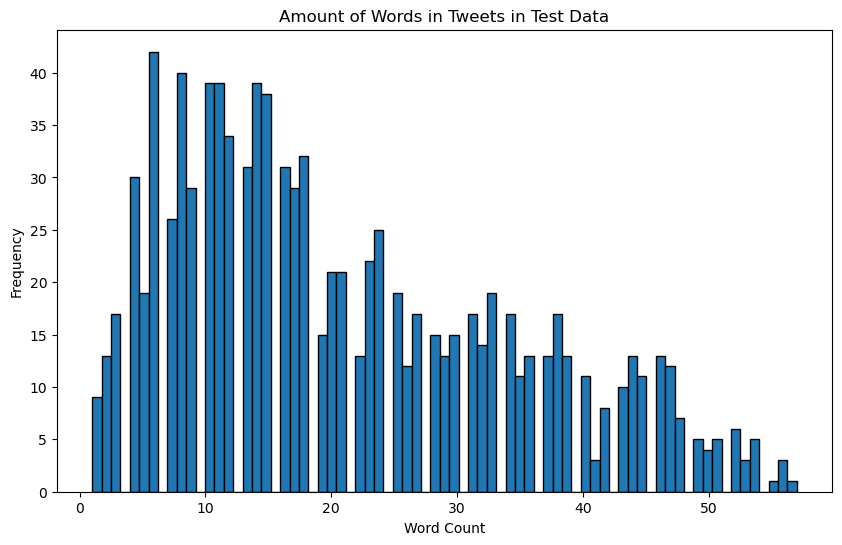

In [270]:
test_df['text_length'] = test_df['text'].apply(len)
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(test_df['text_length'], bins=75, edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Amount of Characters in Tweets in Test Data')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(test_df['word_count'], bins=75, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Amount of Words in Tweets in Test Data')
plt.show()

In [271]:
print("Mean word count:", test_df['word_count'].mean())
print("Mean text length:", test_df['text_length'].mean())

Mean word count: 20.94
Mean text length: 131.849


### Italy?
I decided to take a look at tweets in train dataset that are above 400 characters length. They all have a lot of repetitions. What cought my eye were the multiple appearances of the tweet that contained only word 'Italy'. In whole dataset there are only 9 tweets that contain this word (regardless if its 'italy' or 'Italy'). What's weird here is that the repeating ones have mostly different categories and labels ('type' column) despite being the same. It raises susptions about quality of labeling. Having that in mind I scoped data for a little while but it mostly seemed to be alright. This time I focused on classification but it different setting in should have been checked more thoroughly.

In [272]:
long_tweets = train_df[train_df['text'].apply(len) > 400]

for i, tweet in enumerate(long_tweets['text']):
    print(f"{i})\n{tweet}\n\n\n")

0)
Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy,



1)
Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Ital

In [273]:
italy_tweets = train_df[train_df['text'].str.contains('italy', case=False)].copy()
italy_tweets['word_count'] = italy_tweets['text'].apply(lambda x: len(str(x).split()))
italy_tweets

,id,category,type,text,text_length,word_count
3098,1737,CallOfDutyBlackopsColdWar,Negative,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",692,99
3968,1885,CallOfDutyBlackopsColdWar,Irrelevant,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",692,99
10256,12966,Xbox(Xseries),Neutral,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",692,99
18128,9907,PlayStation5(PS5),Positive,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",692,99
23309,4395,CS-GO,Positive,What a game it played there. BIG did a great j...,216,40
28994,588,ApexLegends,Negative,"At the same time, there are many low-income co...",727,106
36308,8231,Microsoft,Irrelevant,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",692,99
59126,3335,Facebook,Irrelevant,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",692,99
73244,8947,Nvidia,Neutral,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",692,99


In [274]:
for i, tweet in enumerate(italy_tweets['text']):
    print(f"{i})\n{tweet}\n\n\n")

0)
Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy,



1)
Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Ital

In [275]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk

### NLTK
- wytłumacznie czym jest ta biblioteka
- co robi word_tokenize
- co robi pos_tag

In [276]:
train_df['text'][20]

'that was the first borderlands session in a long time where i actually had a really satisfying combat experience. i got some really good kills'

In [277]:
tokens = nltk.word_tokenize(train_df['text'][20])
print(tokens)

['that', 'was', 'the', 'first', 'borderlands', 'session', 'in', 'a', 'long', 'time', 'where', 'i', 'actually', 'had', 'a', 'really', 'satisfying', 'combat', 'experience', '.', 'i', 'got', 'some', 'really', 'good', 'kills']


In [278]:
tags = nltk.pos_tag(tokens)
print(tags)

[('that', 'DT'), ('was', 'VBD'), ('the', 'DT'), ('first', 'JJ'), ('borderlands', 'VBZ'), ('session', 'NN'), ('in', 'IN'), ('a', 'DT'), ('long', 'JJ'), ('time', 'NN'), ('where', 'WRB'), ('i', 'NN'), ('actually', 'RB'), ('had', 'VBD'), ('a', 'DT'), ('really', 'RB'), ('satisfying', 'JJ'), ('combat', 'NN'), ('experience', 'NN'), ('.', '.'), ('i', 'NN'), ('got', 'VBD'), ('some', 'DT'), ('really', 'RB'), ('good', 'JJ'), ('kills', 'NNS')]


In [279]:
entities = nltk.chunk.ne_chunk(tags)

In [280]:
entities.pprint()

(S
  that/DT
  was/VBD
  the/DT
  first/JJ
  borderlands/VBZ
  session/NN
  in/IN
  a/DT
  long/JJ
  time/NN
  where/WRB
  i/NN
  actually/RB
  had/VBD
  a/DT
  really/RB
  satisfying/JJ
  combat/NN
  experience/NN
  ./.
  i/NN
  got/VBD
  some/DT
  really/RB
  good/JJ
  kills/NNS)


### VADER
- co to vader
- co to bag of words
- co to SentimentIntensityAnalyzer
- nie uwzglednia relacji między słowami

In [281]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [282]:
analyzer  = SentimentIntensityAnalyzer()

In [283]:
analyzer .polarity_scores(train_df['text'][20])

{'neg': 0.216, 'neu': 0.568, 'pos': 0.217, 'compound': 0.0076}

## Data Preparation (basic)

In [315]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score

In [316]:
test_df["processed_text"] = test_df.text.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))

In [317]:
test_df['modified_type'] = test_df['type'].replace('Irrelevant', 'Neutral')

In [318]:
vectorizer = CountVectorizer()

WCmatrix = vectorizer.fit_transform(test_df['processed_text'])
WCmatrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [319]:
kmeans = KMeans(init="random", n_clusters=3, random_state=10)
test_df['cluster'] = kmeans.fit_predict(WCmatrix)

C:\Users\maury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [320]:
test_df.groupby(['cluster'])['modified_type'].value_counts()

cluster  modified_type
0        Neutral           61
         Positive          35
         Negative          34
1        Neutral           86
         Negative          70
         Positive          57
2        Neutral          310
         Positive         185
         Negative         162
Name: count, dtype: int64

In [321]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(WCmatrix.toarray())

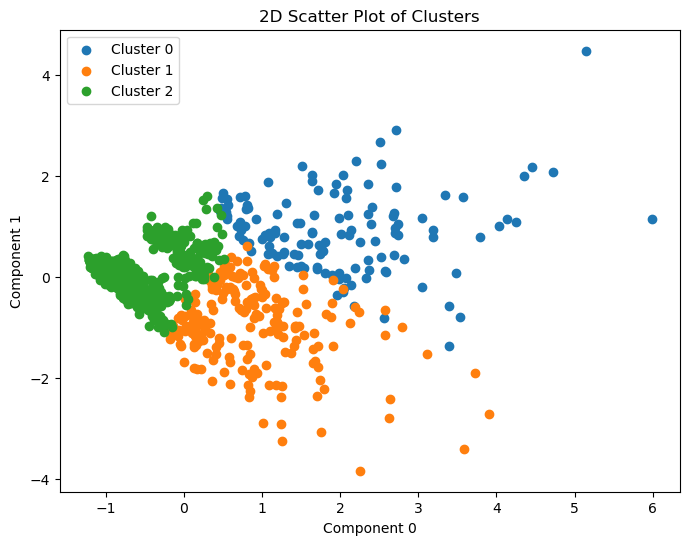

In [322]:
plt.figure(figsize=(8, 6))

for cluster_label in range(3):
    cluster_points = pca_result[test_df['cluster'] == cluster_label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_label}')

plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.title('2D Scatter Plot of Clusters')
plt.legend()

plt.show()

In [323]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(WCmatrix.toarray())

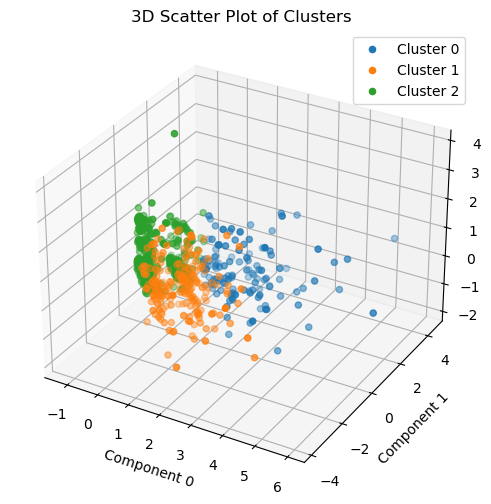

In [324]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for cluster_label in range(3):
    cluster_points = pca_result[test_df['cluster'] == cluster_label]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster_label}')

ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')
ax.set_zlabel('Component 2')
ax.set_title('3D Scatter Plot of Clusters')
ax.legend()

plt.show()

In [325]:
inertia = []
K = range(1,13)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans = kmeans.fit(WCmatrix)
    inertia.append(kmeans.inertia_)

C:\Users\maury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


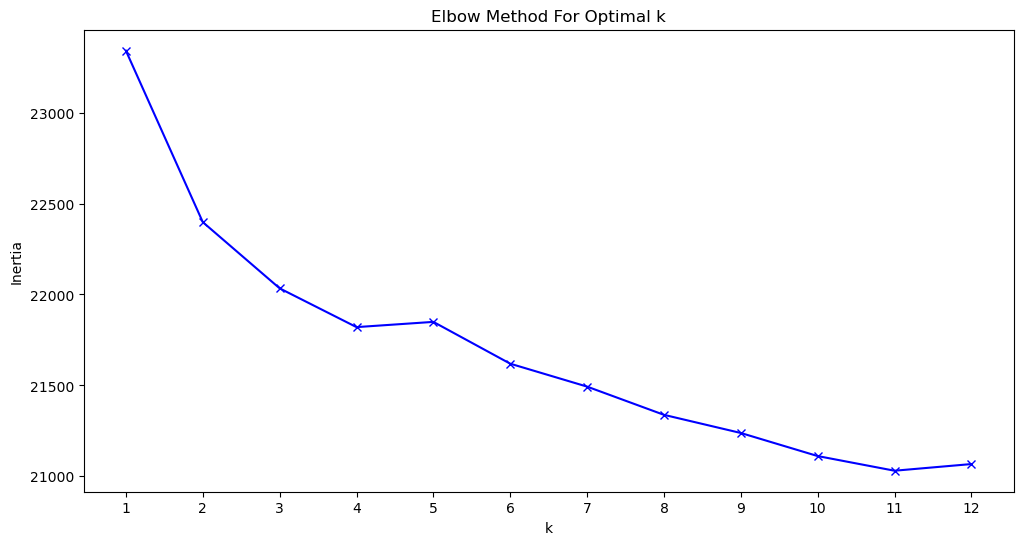

In [326]:
plt.figure(figsize=(12, 6))

plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(range(1, 13))

plt.show()

In [344]:
K = range(2,13)
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=10)
    cluster_labels = kmeans.fit_predict(WCmatrix)
    silhouette_avg = silhouette_score(WCmatrix, cluster_labels)
    silhouette_scores.append(silhouette_avg)

C:\Users\maury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\maury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\maury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\maury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

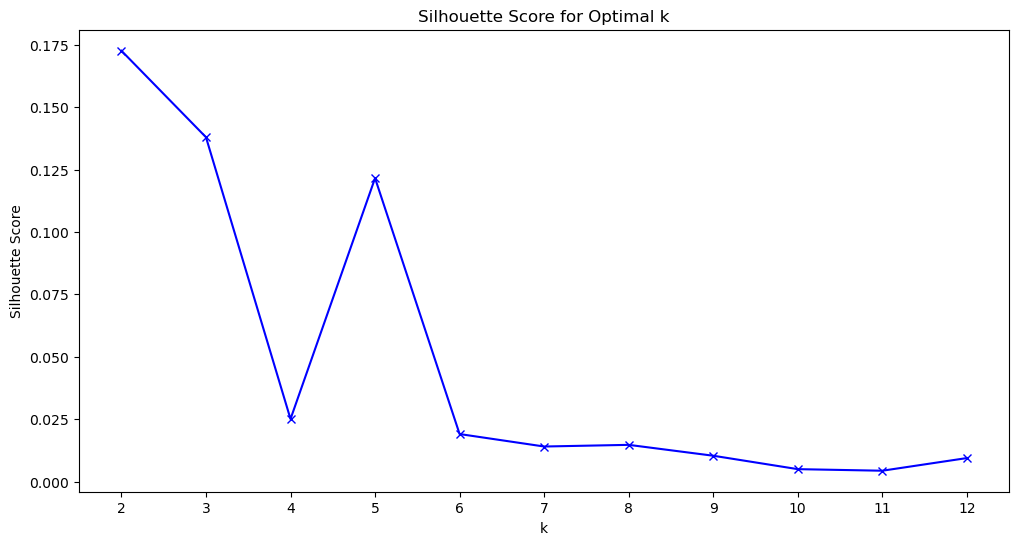

In [343]:
plt.figure(figsize=(12, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.xticks(range(2, 13))
plt.show()

## Data Preparation (more advanced)
- stemming

In [328]:
porter_stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def text_preprocess(data, porter_stemmer, stop_words):
    df = data.str.replace("\n\t", " ")
    df = df.str.replace(r"[^a-zA-Z ]+", "")
    df = df.str.lower()
    df = df.apply(lambda x: ' '.join([porter_stemmer.stem(item) for item in word_tokenize(x) if item not in stop_words]))
    return df

test_df['processed_text'] = text_preprocess(test_df['text'], porter_stemmer, stop_words)

In [329]:
test_df['modified_type'] = test_df['type'].replace('Irrelevant', 'Neutral')

In [330]:
test_df.head()

,id,category,type,text,text_length,word_count,processed_text,modified_type,cluster
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...,242,47,"mention facebook struggl motiv go run day , tr...",Neutral,1
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,109,16,bbc news - amazon boss jeff bezo reject claim ...,Neutral,2
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,91,17,@ microsoft pay word function poorli @ samsung...,Negative,2
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",71,13,"csgo matchmak full closet hack , 's truli aw g...",Negative,2
4,4433,Google,Neutral,Now the President is slapping Americans in the...,170,25,presid slap american face realli commit unlaw ...,Neutral,0


In [331]:
test_df[test_df['type'] == 'Irrelevant'].head()

,id,category,type,text,text_length,word_count,processed_text,modified_type,cluster
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...,242,47,"mention facebook struggl motiv go run day , tr...",Neutral,1
22,2286,CallOfDuty,Irrelevant,Call of duty warzone (livestream) w/ subs #War...,269,43,call duti warzon ( livestream ) w/ sub # warzo...,Neutral,1
27,9449,Overwatch,Irrelevant,They might not be the last team that has to ma...,181,23,might last team make difficult decis . # updat...,Neutral,2
28,10193,PlayerUnknownsBattlegrounds(PUBG),Irrelevant,Best squad yet#pubg #pubgmobile #pubgkenya ins...,72,6,best squad yet # pubg # pubgmobil # pubgkenya ...,Neutral,2
37,12997,Xbox(Xseries),Irrelevant,This is a really disappointing move by Remedy....,189,33,realli disappoint move remedi . bought control...,Neutral,0


In [332]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(test_df['processed_text'])

In [333]:
kmeans = KMeans(init="random", n_clusters=3, random_state=10)
test_df['cluster'] = kmeans.fit_predict(tfidf_matrix)

C:\Users\maury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [334]:
test_df.groupby(['cluster'])['modified_type'].value_counts()

cluster  modified_type
0        Neutral          361
         Negative         234
         Positive         199
1        Neutral           80
         Positive          54
         Negative          28
2        Positive          24
         Neutral           16
         Negative           4
Name: count, dtype: int64

In [335]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

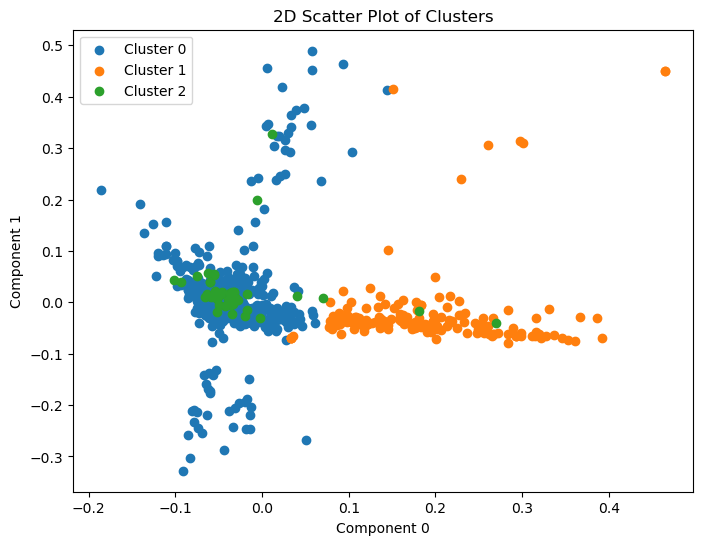

In [336]:
plt.figure(figsize=(8, 6))

for cluster_label in range(3):
    cluster_points = pca_result[test_df['cluster'] == cluster_label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_label}')

plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.title('2D Scatter Plot of Clusters')
plt.legend()

plt.show()

In [337]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

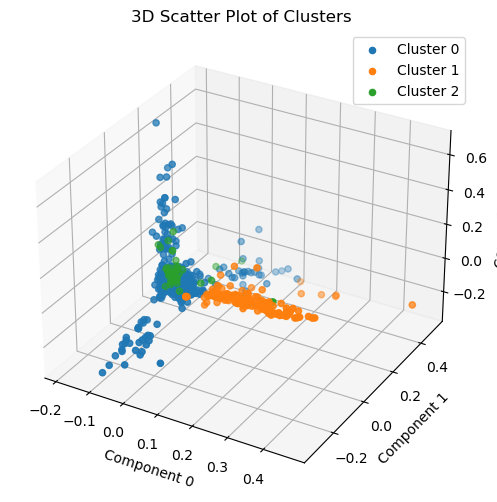

In [338]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for cluster_label in range(3):
    cluster_points = pca_result[test_df['cluster'] == cluster_label]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster_label}')

ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')
ax.set_zlabel('Component 2')
ax.set_title('3D Scatter Plot of Clusters')
ax.legend()

plt.show()

In [339]:
inertia = []
K = range(1,13)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans = kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)

C:\Users\maury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


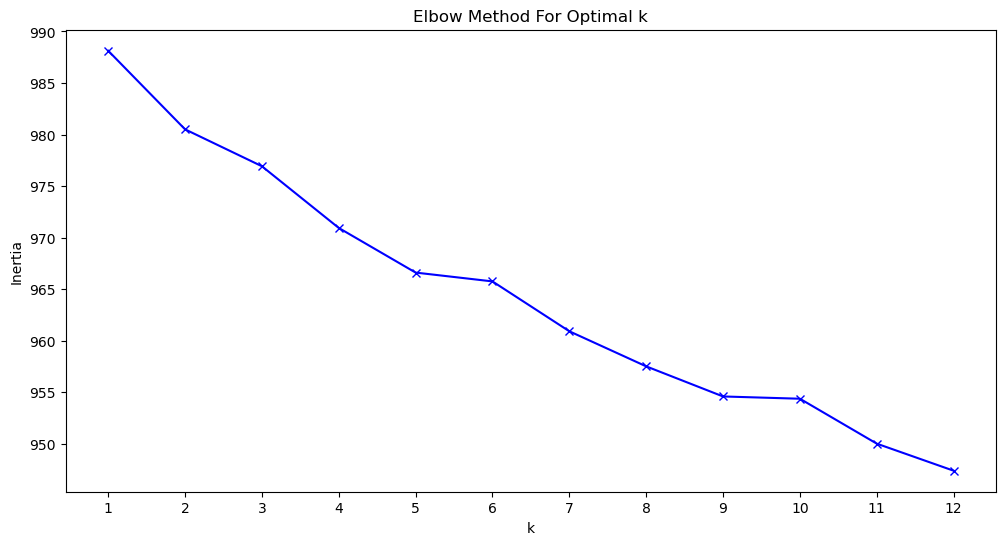

In [340]:
plt.figure(figsize=(12, 6))

plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(range(1, 13))

plt.show()

In [345]:
K = range(2,13)
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=10)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    silhouette_scores.append(silhouette_avg)

C:\Users\maury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\maury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\maury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\maury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

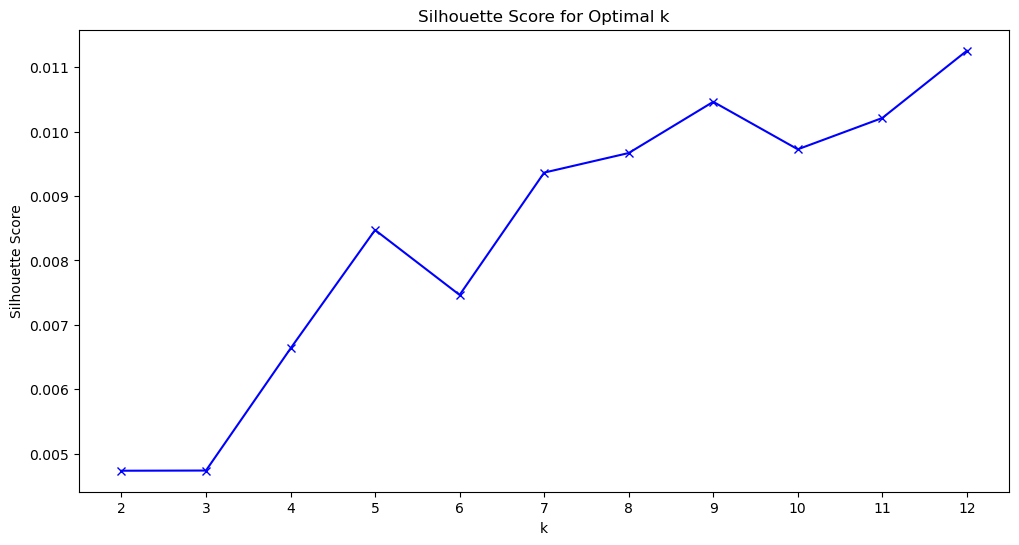

In [346]:
plt.figure(figsize=(12, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.xticks(range(2, 13))
plt.show()

- zrobić komentarze do k-means
- spróbować zrobić na podstawie 1 label i porównać ze wcześniejszymi
- zrobić przykład dla Vadera i porównać label
- napisać o innych opcjach (z tego filmiku) i zrobic komentarze
- zrobić LDA + bag of words (spróbować z sentiment) + napisac komentarze
- zrobic LDA dla kategorii tweetów